In [124]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from matplotlib import pyplot as plt 
import glob
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib import colors, cm
from matplotlib.colors import Normalize
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.lines import Line2D 
from matplotlib.patches import Circle


class MidpointNormalize(Normalize):
    """Normalise the colorbar.  e.g. norm=MidpointNormalize(mymin, mymax, 0.)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
    #get viridis colormaps
def cmap_codes(name, number):
    cmap = cm.get_cmap(name, number) 
    hexcodes = []
    for i in range(cmap.N): 
        hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    return hexcodes

In [86]:
path = '/Users/rogercreel/Desktop/readv_output_020320/'

names_glac = glob.glob(path + 'glac*modelaverage*')
names_6g = glob.glob(path + 'd6g*modelaverage*')

def process(name):
    
    ds = xr.open_dataset(name)
    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
    except:
        pass
    try:
        ds = ds.drop('scale')
    except:
        pass
    return ds


ds_glaczp = process(names_glac[0])
ds_glacpost = process(names_glac[1])
ds_glacprior = process(names_glac[2])
ds_glacvar = process(names_glac[4])

ds_6gprior = process(names_6g[0])
ds_6gvar = process(names_6g[2])
ds_6gzp = process(names_6g[3])
ds_6gpost = process(names_6g[4])

# Load GIA models to take STD

In [279]:
def build_dataset(path, model):
    """download model runs from local directory."""
    path = path
    files = f'{path}*.nc'
    basefiles = glob.glob(files)
    modelrun = [
        key.split('output_', 1)[1][:-3].replace('.', '_')
        for key in basefiles
    ]
    dss = xr.open_mfdataset(files,
                            chunks=None,
                            concat_dim='modelrun',
                            combine='nested')
    lats, lons, times = dss.LAT.values[0], dss.LON.values[
        0], dss.TIME.values[0]
    ds = dss.drop(['LAT', 'LON', 'TIME'])
    ds = ds.assign_coords(lat=lats,
                          lon=lons,
                          time=times,
                          modelrun=modelrun).rename({
                              'time': 'age',
                              'RSL': 'rsl'
                          })
    return ds

def one_mod(path, names):
    """Organize model runs into xarray dataset."""
    ds1 = build_dataset(path, names[0])
    names = names[1:]
    ds = ds1.chunk({'lat': 10, 'lon': 10})
    for i in range(len(names)):
        temp = build_dataset(names[i])
        temp1 = temp.interp_like(ds1)
        temp1['modelrun'] = temp['modelrun']
        ds = xr.concat([ds, temp1], dim='modelrun')
    ds['age'] = ds['age'] * 1000
    ds = ds.roll(lon=256, roll_coords=True)
    ds.coords['lon'] = pd.DataFrame((ds.lon[ds.lon >= 180] - 360)- 0.12 ) \
                            .append(pd.DataFrame(ds.lon[ds.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds.coords['lat'] = ds.lat[::-1]
    ds = ds.swap_dims({'dim_0': 'lon'}).drop('dim_0')
    return ds

#make stds of each ice model
path = f'/Users/rogercreel/Desktop/readv_files/glac1d_/output_glac1d_l71C'
ds = one_mod(path, [model])
ds_glacsliced = ds.assign_coords({'lat':ds.lat.values[::-1]}).rsl.sel(lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.max() + 2,
                                 df_place.lat.min() - 2))
ds_glac71 = ds_glacsliced.mean(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)
ds_glacstd71 = ds_glacsliced.std(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)


path = f'/Users/rogercreel/Desktop/readv_files/glac1d_/output_glac1d_l96C'
ds = one_mod(path, [model])
ds_glacsliced = ds.assign_coords({'lat':ds.lat.values[::-1]}).rsl.sel(lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.max() + 2,
                                 df_place.lat.min() - 2))
ds_glac96 = ds_glacsliced.mean(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)
ds_glacstd96 = ds_glacsliced.std(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)


path = f'data/d6g_h6g_/output_d6g_h6g_l71C'
ds = one_mod(path, [model])
ds_6gsliced = ds.assign_coords({'lat':ds.lat.values[::-1]}).rsl.sel(lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.max() + 2,
                                 df_place.lat.min() - 2))
ds_6g71 = ds_6gsliced.mean(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)
ds_6gstd71 = ds_6gsliced.std(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)


path = f'data/d6g_h6g_/output_d6g_h6g_l96C'
ds = one_mod(path, [model])
ds_6gsliced = ds.assign_coords({'lat':ds.lat.values[::-1]}).rsl.sel(lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.max() + 2,
                                 df_place.lat.min() - 2))
ds_6g96 = ds_6gsliced.mean(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)
ds_6gstd96 = ds_6gsliced.std(dim='modelrun').load().to_dataset().interp(lon=ds_readv.lon, lat=ds_readv.lat)

#calculate STD for all model runs
ds_glacstd = xr.ufuncs.sqrt((xr.ufuncs.square(ds_glacstd71.rsl) + xr.ufuncs.square(ds_glacstd96.rsl))/2 + \
            xr.ufuncs.square(xr.concat([ds_glac71,ds_glac96], dim='model').std(dim='model')))

ds_6gstd = xr.ufuncs.sqrt((xr.ufuncs.square(ds_6gstd71.rsl) + xr.ufuncs.square(ds_6gstd96.rsl))/2 + \
            xr.ufuncs.square(xr.concat([ds_6g71,ds_6g96], dim='model').std(dim='model'))).transpose()

ds_glacmean = (ds_glac96 + ds_glac71)/2
ds_6gmean = (ds_6g96 + ds_6g71)/2

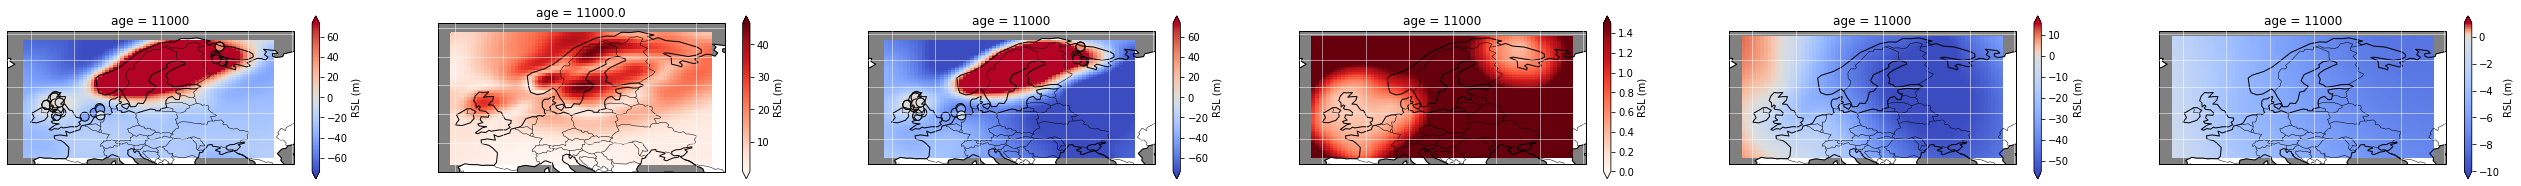

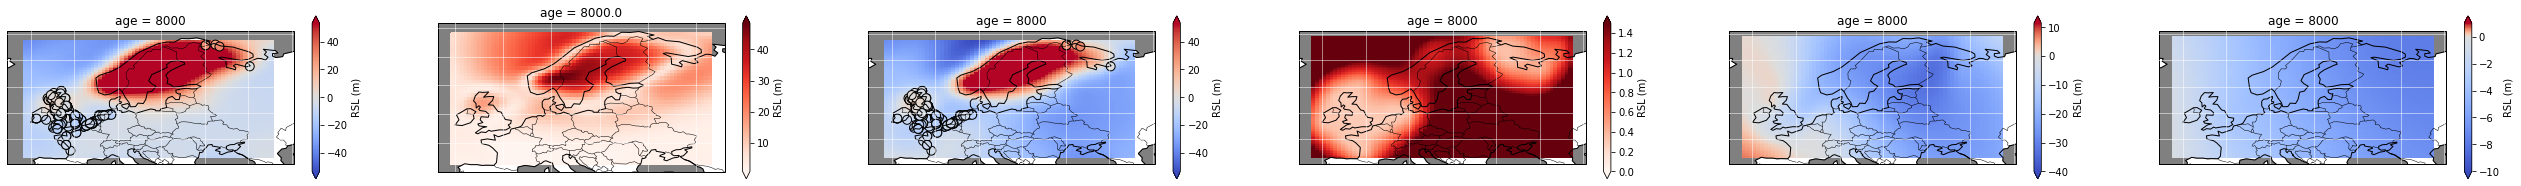

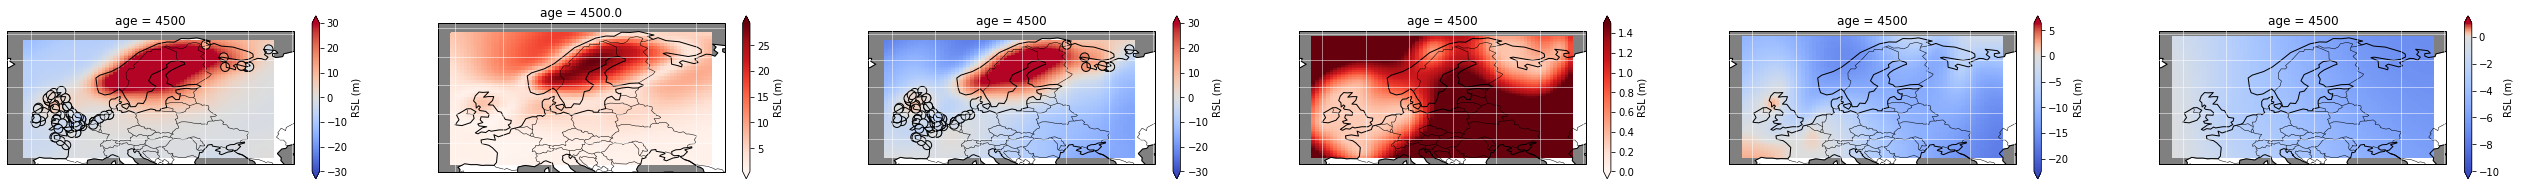

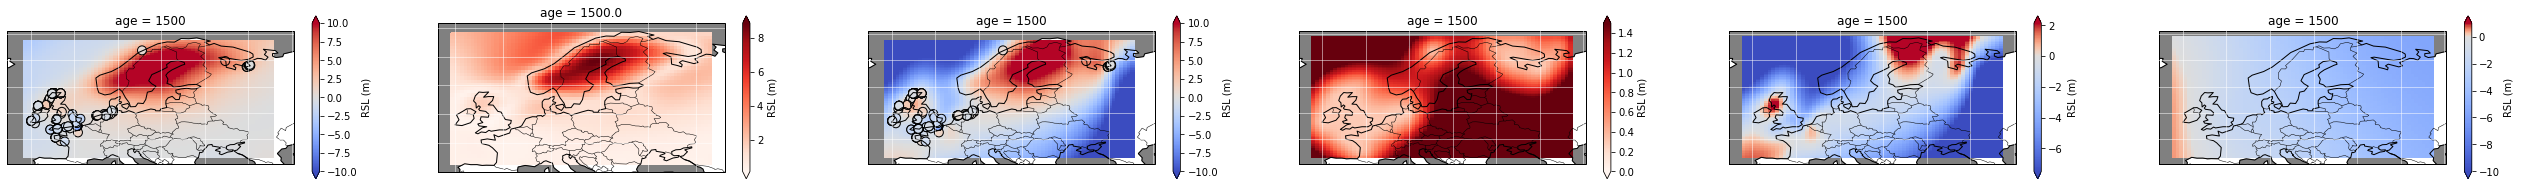

In [663]:
proj = ccrs.PlateCarree()

ages = [11000, 8000, 4500, 1500]
cbar_kwargs = {'shrink': 0.3,'label':'RSL (m)'}
vmin=-100
vmax=100
vmin_var = -0.1
vmax_var = 10
fontsize=16

# ax = plt.axes(projection=ccrs.PlateCarree())


def make_ax(num):
    ax[num].coastlines(resolution='110m', linewidth=1, zorder=2)
    ax[num].add_feature(cfeature.OCEAN, color='gray', zorder=0)
    ax[num].add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax[num].gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

for i, age in enumerate(ages):
    
    fig, ax = plt.subplots(1, 6, figsize=(45, 10), subplot_kw=dict(projection=proj))
    ax=ax.flatten()
    
    step = (ages[0] - ages[1])
    df_it = df_place[(df_place.age < age) & (df_place.age > age - step/4)]
    rsl, var = df_it.rsl, df_it.rsl_er_max.values**2
    lat_it, lon_it = df_it.lat, df_it.lon
    vmin=-age/150
    vmax=age/150

    vminpost=-age/200
    vmaxpost=age/700
    
    make_ax(0)
    ds_glacprior.rsl.sel(age=age).plot(ax=ax[0], cmap='coolwarm', norm=MidpointNormalize(vmin, vmax, 0),
                                                          cbar_kwargs=cbar_kwargs, extend='both')
    scat = ax[0].scatter(lon_it, lat_it, s=80, c=rsl,edgecolor='k', norm=MidpointNormalize(vmin, vmax, 0), cmap='coolwarm')
#     ax[0].set_title(f'{ice_model[1][:-1]}: GIA prior model mean\n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[0])
#     ax[0].annotate('A', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    
    
    make_ax(1)
    (ds_glacstd.rsl * 2).transpose().sel(age=age).plot(ax=ax[1],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both')
#     ax[1].set_title(f'{ice_model[1][:-1]}: GIA prior model 2 $\sigma$ \n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[1])
#     ax[0].annotate('B', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    
    make_ax(2)
    ds_glacpost.rsl.sel(age=age).plot(ax=ax[2],cmap='coolwarm', norm=MidpointNormalize(vmin, vmax, 0),
                                      cbar_kwargs=cbar_kwargs, extend='both')
    scat = ax[2].scatter(lon_it, lat_it, s=80, c=rsl, edgecolor='k', norm=MidpointNormalize(vmin, vmax, 0), cmap='coolwarm')
#     ax[2].set_title(f'{ice_model[1][:-1]}: GPR posterior RSL \n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[2])
#     ax[0].annotate('C', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    

    make_ax(3)
    (np.sqrt(ds_glacvar.rsl) * 2 ).sel(age=age).plot(ax=ax[3],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both', vmin=0, vmax=1.5)
#     ax[3].set_title(f'{ice_model[1][:-1]}: GPR posterior 2 $\sigma$, \n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[3])
#     ax[3].annotate('D', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    
    make_ax(4)
    ds_glaczp.rsl.sel(age=age).plot(ax=ax[4],cmap='coolwarm', cbar_kwargs=cbar_kwargs, norm=MidpointNormalize(vminpost, vmaxpost, 0), extend='both')
#     ax[4].set_title(f'{ice_model[1][:-1]}: GPR residual \n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[4])
#     ax[4].annotate('E', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    
    make_ax(5)
    ds_6gzp.rsl.sel(age=age).plot(ax=ax[5],cmap='coolwarm', cbar_kwargs=cbar_kwargs, norm=MidpointNormalize(-10, 1, 0), extend='both')
#     ax[5].set_title(f'ice6g: GPR residual \n age = {age} ka', fontsize=fontsize)
#     transform = proj._as_mpl_transform(ax[5])
#     ax[5].annotate('F', xy=(-9, 79.9), xycoords=transform,
#             ha='right', va='top', color='k', fontsize=30)
    
    

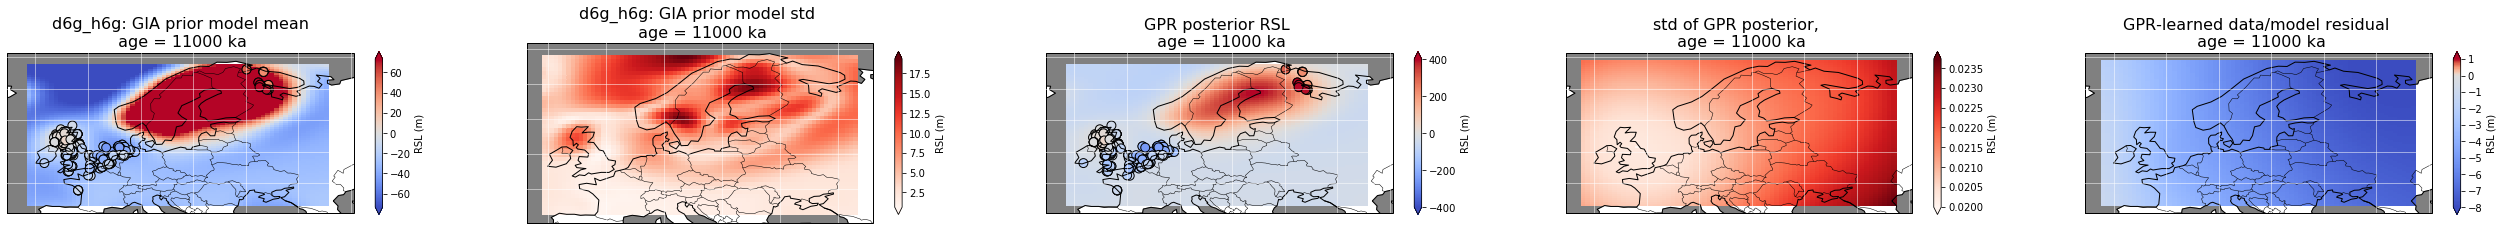

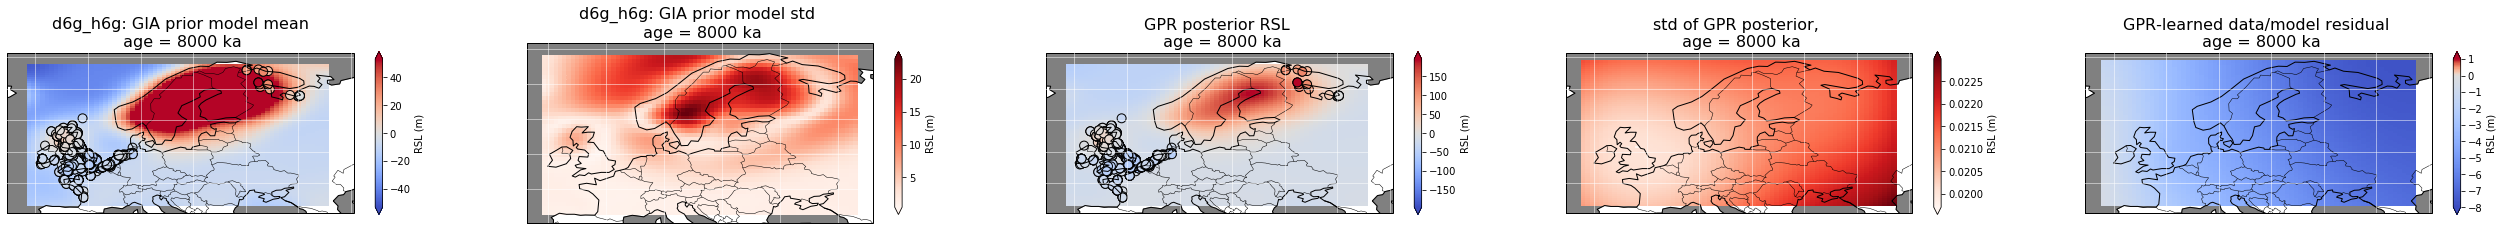

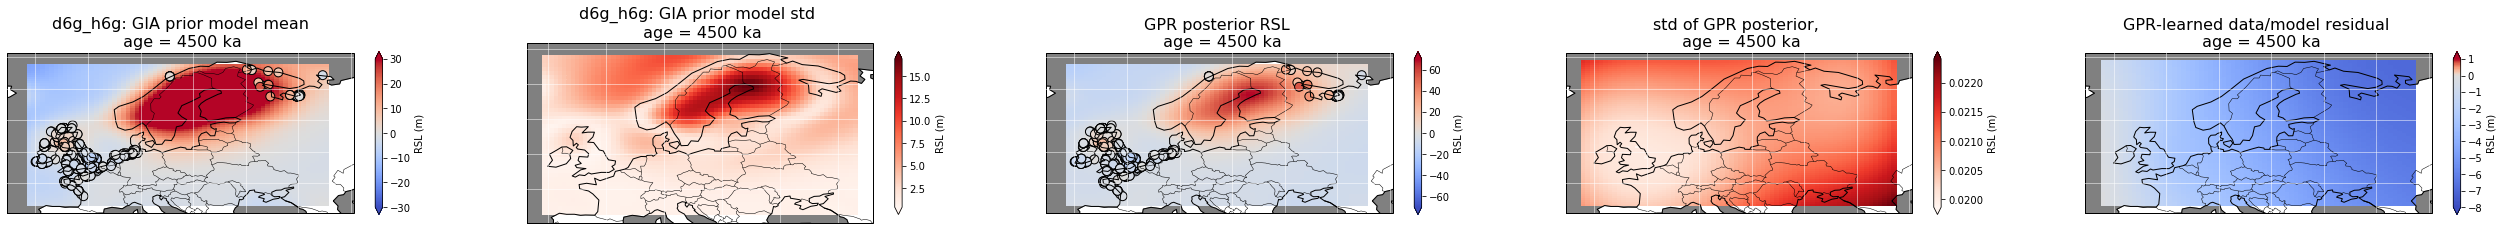

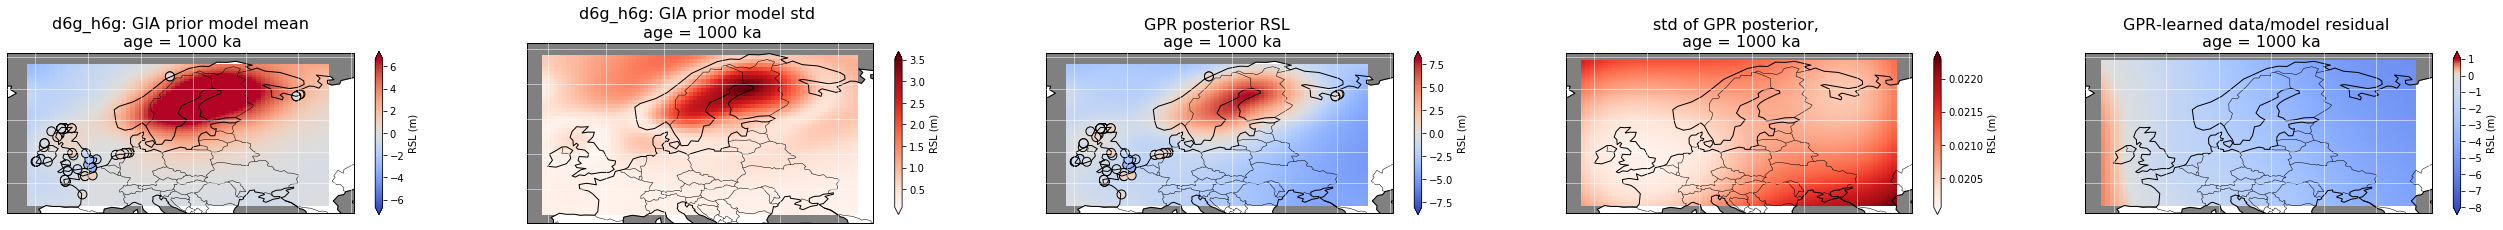

In [614]:
proj = ccrs.PlateCarree()

ages = [11000, 8000, 4500, 1000]
cbar_kwargs = {'shrink': 0.3,'label':'RSL (m)'}
vmin=-100
vmax=100
vmin_var = -0.1
vmax_var = 10
fontsize=16

def make_ax(num):
    ax[num].coastlines(resolution='110m', linewidth=1, zorder=2)
    ax[num].add_feature(cfeature.OCEAN, color='gray', zorder=0)
    ax[num].add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax[num].gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

for i, age in enumerate(ages):
    
    step = (ages[0] - ages[1])
    df_it = df_place[(df_place.age < age) & (df_place.age > age - step)]
    rsl, var = df_it.rsl, df_it.rsl_er_max.values**2
    lat_it, lon_it = df_it.lat, df_it.lon
    vmin=-age/150
    vmax=age/150
    
    vminpost= -8 # -age/500
    vmaxpost=1 # age/1000
    
    fig, ax = plt.subplots(1, 5, figsize=(45, 10), subplot_kw=dict(projection=proj))
    ax=ax.flatten()
    
    make_ax(0)
    ds_6gprior.rsl.sel(age=age).plot(ax=ax[0], cmap='coolwarm', norm=MidpointNormalize(vmin, vmax, 0),
                                                          cbar_kwargs=cbar_kwargs, extend='both')
    scat = ax[0].scatter(lon_it, lat_it, s=80, c=rsl,edgecolor='k', norm=MidpointNormalize(vmin, vmax, 0), cmap='coolwarm')

    ax[0].set_title(f'{ice_model[0][:-1]}: GIA prior model mean\n age = {age} ka', fontsize=fontsize)
    
    make_ax(1)
    ds_6gstd.rsl.sel(age=age).plot(ax=ax[1],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[1].set_title(f'{ice_model[0][:-1]}: GIA prior model std \n age = {age} ka', fontsize=fontsize)
    
       
    make_ax(2)
    ds_6gpost.rsl.sel(age=age).plot(ax=ax[2],cmap='coolwarm', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    scat = ax[2].scatter(lon_it, lat_it, s=80, c=rsl, edgecolor='k', norm=MidpointNormalize(vmin, vmax, 0), cmap='coolwarm')

    ax[2].set_title(f'GPR posterior RSL \n age = {age} ka', fontsize=fontsize)
    
    make_ax(3)
    ds_6gvar.rsl.sel(age=age).plot(ax=ax[3],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[3].set_title(f'std of GPR posterior, \n age = {age} ka', fontsize=fontsize)
    
    make_ax(4)
    ds_6gzp.rsl.sel(age=age).plot(ax=ax[4],cmap='coolwarm', norm=MidpointNormalize(vminpost, vmaxpost, 0),
                                  cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[4].set_title(f'GPR-learned data/model residual \n age = {age} ka', fontsize=fontsize)

# Load Holocene Data

In [104]:
#load RSL data

tmax = '12010'
tmin = '490'

tmax, tmin, tstep = int(tmax), int(tmin), 100

ages_lgm = np.arange(100, 26000, tstep)[::-1]

#import khan dataset
path = 'data/GSL_LGM_120519_.csv'

df = pd.read_csv(path, encoding="ISO-8859-15", engine='python')
df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
        applymap(lambda s:s.lower() if type(s) == str else s)
df.columns = df.columns.str.lower()
df.rename_axis('index', inplace=True)
df = df.rename({'latitude': 'lat', 'longitude': 'lon'}, axis='columns')
dfind, dfterr, dfmar = df[(df.type == 0)
                          & (df.age > 0)], df[df.type == 1], df[df.type == -1]
np.sort(list(set(dfind.regionname1)))

#select location
df_pl = dfind[(dfind.age > tmin) & (dfind.age < tmax) &
                 (dfind.lon > extent[0])
                 & (dfind.lon < extent[1])
                 & (dfind.lat > extent[2])
                 & (dfind.lat < extent[3])]

# [['lat', 'lon', 'rsl', 'rsl_er_max', 'age']]
df_place = df_pl[['lat', 'lon', 'rsl', 'rsl_er_max', 'age']]

#Import new Fennoscandia database
path = '/Users/rogercreel/ws/Holocene_readv/data/holocene_fennoscandian_data.csv'
df_newlocs = pd.read_csv(path, header=2)[2:].rename({'Latitude':'lat', 'Longitude':'lon', 'Column heading': 'col_head'}, axis='columns')
df_newlocs['lon'] = df_newlocs.lon.astype(float)
df_newlocs['lat'] = df_newlocs.lat.astype(float)

# Make 1D plots

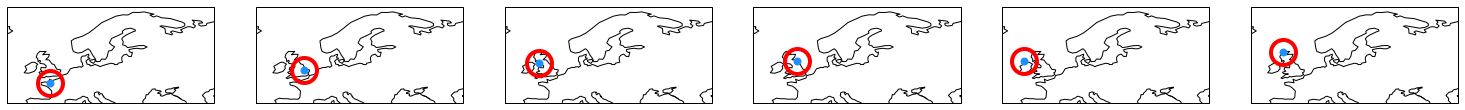

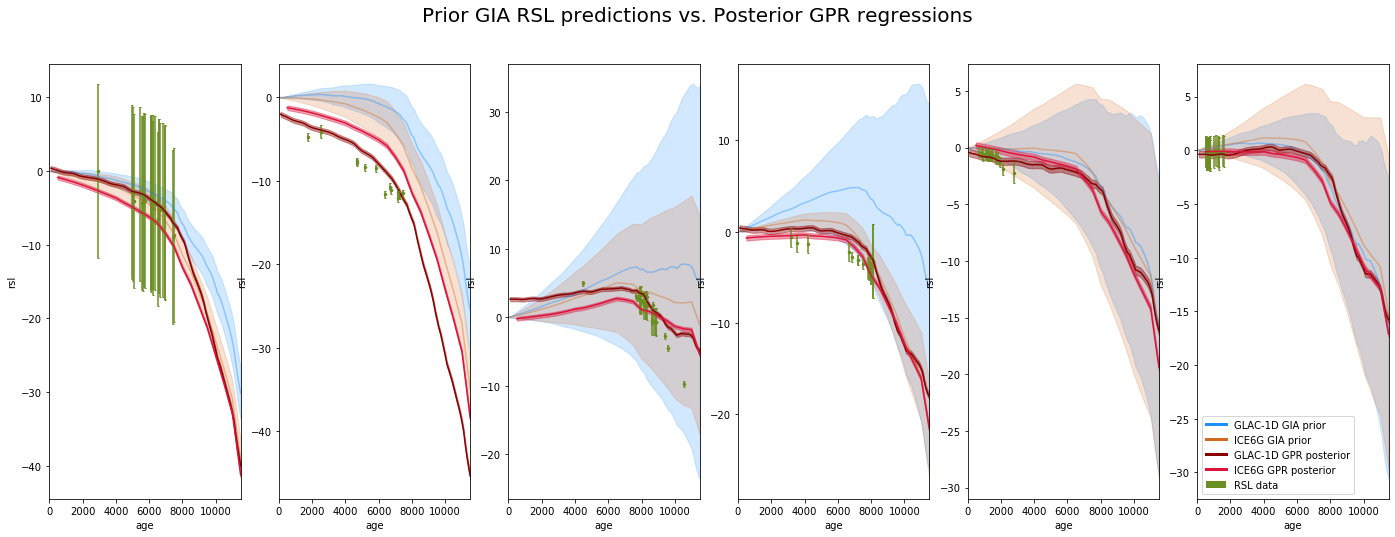

In [615]:
tmin = 500

def locs_with_enoughsamples(df_place, place, number):
    """make new dataframe, labeled, of sites with [> number] measurements"""
    df_lots = df_place.groupby(['lat',
                                'lon']).filter(lambda x: len(x) > number)

    df_locs = []
    for i, group in enumerate(df_lots.groupby(['lat', 'lon'])):
        singleloc = group[1].copy()
        singleloc['location'] = place
        singleloc['locnum'] = place + '_site' + str(
            i)  # + singleloc.reset_index().index.astype('str')
        df_locs.append(singleloc)
    df_locs = pd.concat(df_locs)

    return df_locs
if tmin == 500:
    number = 14
if tmin == 2000:
    number = 8
elif tmin == 6000:
    number = 5
elif tmin == 9000:
    number = 2

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def interp_ds(ds):
    return ds.interp(age=ds_glacprior.age, lat=ds_glacprior.lat, lon=ds_glacprior.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(11500, 0))


###### Plot Locations #####
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,len(nufsamp)-3, figsize=(26, 6), subplot_kw=dict(projection=proj))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_glacprior.rsl[:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=proj)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=proj,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False)
#     ax[i].set_title(site[0], fontsize=fontsize)
    ax[i].set_title('')
    if i > 4:
        break


##### Plot Data-Model fit ######
colormark = ['dodgerblue', 'chocolate', 'darkred', 'crimson', 'olivedrab']
cmaps = cmap_codes('viridis', len(df_nufsamps))
    

###################################################################

fig, ax = plt.subplots(1, len(nufsamp)-3, figsize=(24, 8))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20)

    #slice data for each site
    prior_it6g = slice_dataset(ds_6gmean) # [:,:,:-4]
    var_it6gprior = slice_dataset(ds_6gstd)
    top6g_prior = prior_it6g + var_it6gprior * 2
    bottom6g_prior = prior_it6g - var_it6gprior * 2


    post_it6g = slice_dataset(ds_6gpost)
    var_it6g = slice_dataset(np.sqrt(ds_6gvar))
    top6g = post_it6g + var_it6g * 2
    bottom6g = post_it6g - var_it6g * 2
    
    
    
    prior_itglac = slice_dataset(ds_glacmean)
    var_itglacprior = slice_dataset(ds_glacstd)
    topglac_prior = prior_itglac + var_itglacprior * 2
    bottomglac_prior = prior_itglac - var_itglacprior * 2
    
    post_itglac = slice_dataset(ds_glacpost)
    var_itglac = slice_dataset(np.sqrt(ds_glacvar))
    topglac = post_itglac + var_itglac * 2
    bottomglac = post_itglac - var_itglac * 2
    
    
    site_err = 2 * (site[1].rsl_er_max)

    prior_itglac.plot(ax=ax[i], c=colormark[0], alpha=0.4, label='GLAC-1D GIA prior')
    ax[i].fill_between(prior_itglac.age, bottomglac_prior.squeeze(), topglac_prior.squeeze(), color=colormark[0], alpha=0.2) 

    prior_it6g.plot(ax=ax[i], c=colormark[1], alpha=0.4, label='ICE6G GIA prior')
    ax[i].fill_between(prior_it6g.age, bottom6g_prior.squeeze(), top6g_prior.squeeze(), color=colormark[1], alpha=0.2) 


    post_itglac.plot(ax=ax[i], lw=lw, c=colormark[2], alpha=1, label='GLAC-1D GPR posterior')
    ax[i].fill_between(post_itglac.age, bottomglac.squeeze(), topglac.squeeze(), color=colormark[2], alpha=0.4)


    post_it6g.plot(ax=ax[i], lw=lw, c=colormark[3], alpha=1, label='ICE6G GPR posterior')
    ax[i].fill_between(post_it6g.age, bottom6g.squeeze(), top6g.squeeze(), color=colormark[3], alpha=0.4) 

    
    ax[i].scatter(site[1].age, site[1].rsl, c=colormark[4], s=4, lw=lw,label='RSL data')
    ax[i].errorbar(site[1].age, site[1].rsl,site_err, c=colormark[4], fmt='none',
                   capsize=1,lw=1.5)

    ax[i].set_xlim(0, 11500)
#     ax[i].set_ylim(-40,5)
    ax[i].set_title('')
    if i > 4:
        break

lines = [Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'), 
         Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=colormark[2], linewidth=3, linestyle='-'), 
         Line2D([0], [0], color=colormark[3], linewidth=3, linestyle='-'),
         Circle([0], 0.1, color=colormark[4], linewidth=3, ec="none")]

labels = ['GLAC-1D GIA prior','ICE6G GIA prior', 'GLAC-1D GPR posterior', 'ICE6G GPR posterior', 'RSL data']
ax[i].legend(lines, labels, loc='lower left')

#         fig.savefig(dirName + f'{path_gen}_1Dfig',
#                     transparent=True)
plt.show()

In [471]:
np.array(ds_6gzp.rsl).shape

(116, 70, 70)

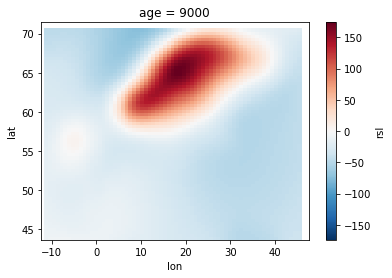

In [499]:
ds_glacpost.rsl[30].plot()

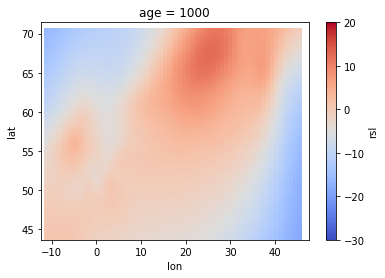

In [566]:
ds_glacpost.rsl[110,:,:].plot(vmin=-30, vmax=20, cmap='coolwarm')

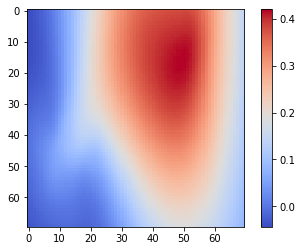

In [572]:
test = np.gradient(np.array(ds_glaczp.rsl))
test2 = np.array(ds_glacpost.rsl)
plt.imshow(test[0][110,::-1,:], cmap='coolwarm')
plt.colorbar()

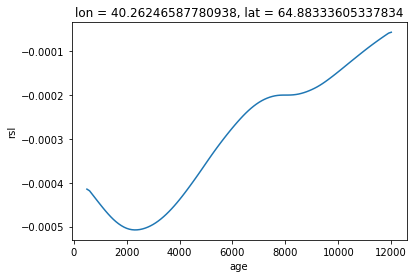

In [189]:
ds_6gzp.sel(lat=65, lon=40, method='nearest').differentiate(coord='age').rsl.plot()

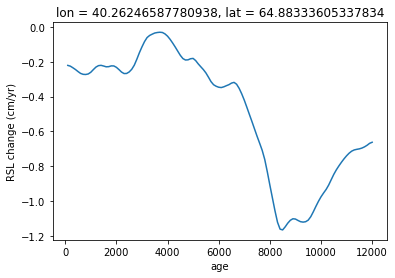

In [356]:
(ds_glaczp.sel(lat=65, lon=40, method='nearest').differentiate(coord='age').rsl * 100).plot()
plt.ylabel('RSL change (cm/yr)');

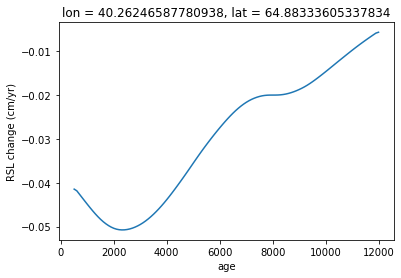

In [357]:
(ds_6gzp.sel(lat=65, lon=40, method='nearest').differentiate(coord='age').rsl * 100).plot()
plt.ylabel('RSL change (cm/yr)');

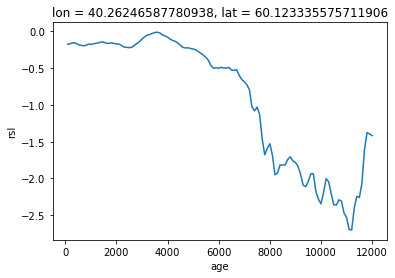

In [358]:
(ds_glacpost.sel(lat=60, lon=40, method='nearest').differentiate(coord='age').rsl * 100).plot()

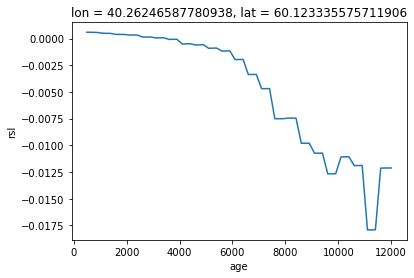

In [423]:
ds_6gpost.sel(lat=60, lon=40, method='nearest').differentiate(coord='age').rsl.plot()